In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt

import settings as s
import Hearis as h
from Custom import Mouse

import scipy.io as sio

batch = s.Batch()

water_path = '/home/pouple/PhD/Code/MFB_Paper/Water'
mfb_path = '/home/pouple/PhD/Code/MFB_Paper/MFB'

plt.style.use('fivethirtyeight')

In [2]:
# Paths for MFB data
# Paths for Water Data
mice_id = batch.id_first_batch
mice_water = [Mouse(path=os.path.join(water_path, f), tag=['PC'], collab=False, rmgaps=False) for f in mice_id]

Processing files for mice 660459...
PC_08022021_660459_1.DAT
PC_05022021_660459_1.DAT
PC_11022021_660459_1.DAT
PC_01022021_660459_1.DAT
PC_12022021_660459_1.DAT
PC_28012021_660459_1.DAT
PC_03022021_660459_1.DAT
PC_02022021_660459_1.DAT
PC_29012021_660459_1.DAT
PC_04022021_660459_1.DAT
PC_10022021_660459_1.DAT
PC_09022021_660459_1.DAT
PC_27012021_660459_1.DAT
Processing files for mice 660461...
PC_01022021_660461_1.DAT
PC_03022021_660461_1.DAT
PC_12022021_660461_1.DAT
PC_18022021_660461_1.DAT
PC_23022021_660461_1.DAT
PC_11022021_660461_1.DAT
PC_09022021_660461_1.DAT
PC_02022021_660461_1.DAT
PC_10022021_660461_1.DAT
PC_16022021_660461_1.DAT
PC_17022021_660461_1.DAT
PC_22022021_660461_1.DAT
PC_04022021_660461_1.DAT
PC_19022021_660461_1.DAT
PC_08022021_660461_1.DAT
PC_05022021_660461_1.DAT
PC_25022021_660461_1.DAT
PC_26022021_660461_1.DAT
Processing files for mice 660462...
PC_08022021_660462_1.DAT
PC_11022021_660462_1.DAT
PC_04022021_660462_1.DAT
PC_12022021_660462_2.DAT
PC_01022021_66046

In [3]:
# Load MFB mice data
path = '/home/pouple/PhD/Code/MFB_Paper/MFB/Psychophysics_MFB'
mice_mfb = os.listdir(path)
paths = [os.path.join(path, f) for f in os.listdir(path)]
#mice_mfb = [sio.loadmat(os.path.join(path, mouse)) for mouse in mice_mfb]

In [4]:
class MouseMFB(object):
    def __init__(self, path):
        self.path = path
        data = self.__load_data(self.path)
        self.day = data['Day']
        self.corr = data['Correct']
        self.idsound = data['SoundId']
        self.idtrial = data['TrialId']
        self.rule = data['Rule']
        
        self.split_in_sessions()
        
        print('Mouse', os.path.basename(self.path)[1:-4], 'Loaded')
    
    def __load_data(self, path):
        return sio.loadmat(path)
    
    def split_in_sessions(self):
        self.corrs = []
        self.idsounds = []
        self.idtrials = []
        for day in np.unique(self.day):
            indices = np.where(self.day == day)
            self.corrs.append(self.corr[indices])
            self.idsounds.append(self.idsound[indices])
            self.idtrials.append(self.idtrial[indices])
    
    def get_session_score(self):
        scores = [np.sum(corr)*100/len(corr) for corr in self.corrs]
        return scores
    
    def get_best_sessions_scores(self, n_sess):
        best_sess = np.argsort(self.get_session_score())[-n_sess:]
        return best_sess
    def keep_best_sessions(self, n_sess):
        best_sess = self.get_best_sessions_scores(n_sess)
        self.best_corrs = list(np.array(self.corrs, dtype=object)[best_sess])
        self.best_idsounds = list(np.array(self.idsounds, dtype=object)[best_sess])
        self.best_idtrials = list(np.array(self.idtrials, dtype=object)[best_sess])
            
        
            
            
        

In [5]:
mice_mfb = [MouseMFB(path) for path in paths]

Mouse 738556 Loaded
Mouse 738552 Loaded
Mouse 738557 Loaded
Mouse 708322 Loaded
Mouse 709221 Loaded
Mouse 738555 Loaded
Mouse 738551 Loaded
Mouse 713559 Loaded


In [7]:
# Select only best performing sessions
mice_best = [mice.select_best_trials(3) for mice in mice_water]
for mouse in mice_mfb: mouse.keep_best_sessions(3)


Best scores are : [90.     90.3125 90.625 ]
Best scores are : [84.375  85.625  89.0625]
Best scores are : [91.875 92.5   94.375]
Best scores are : [90.3125 91.5625 92.5   ]
Best scores are : [87.1875 89.375  89.375 ]
Best scores are : [86.875 87.5   91.25 ]
Best scores are : [84.6875 85.9375 91.25  ]


### Observation 
There seems to be a log preference shape whern looking at individual mouse in the no go section

(8, 16)


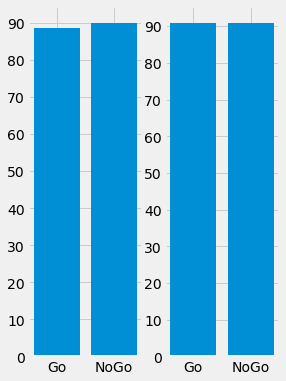

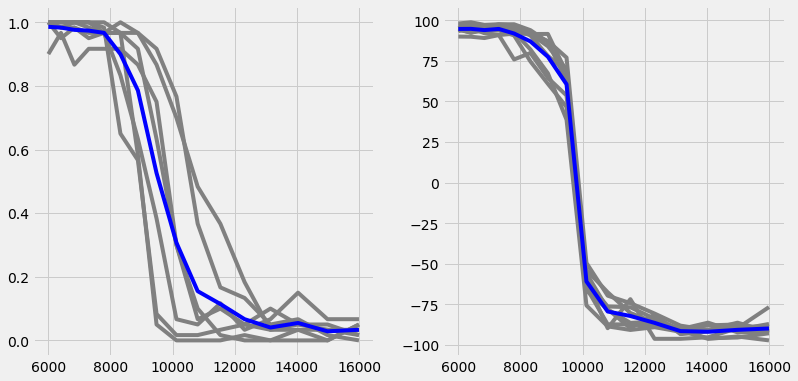

In [12]:
# Peak performance : bar plot go vs nogo sur les 2/3 meilleures sessions + la courbe PS

scores_water = np.array([mouse.score_by_task(plot=False) for mouse in mice_water])
mean_scores_water = np.mean(scores_water, axis=0)

scores_mfb = np.empty((len(mice_mfb), 16))
for i, mouse in enumerate(mice_mfb):
    all_taskid = np.concatenate(mouse.best_idsounds)
    all_corr = np.concatenate(mouse.best_corrs)
    
    for t in np.sort(np.unique(all_taskid)):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = all_corr[idxs]
        scores_mfb[i] = (np.sum(curr_corr)*100/len(curr_corr))
mean_scores_mfb = np.mean(scores_mfb, axis=0)

# Psycoacoustics 
probs = np.array([mouse.psychoacoustic(plot=False)[1] for mouse in mice_water])
reverse = [mouse.reversed for mouse in mice_water]
probs = [np.abs(1-p) if reverse[i] else p for i, p in enumerate(probs)]

######## THIS IS NOT WORKING, RECALCULATE PSYCOCURVE
psycos_mfb = np.empty((len(mice_mfb), 16))
for i, mouse in enumerate(mice_mfb):
    all_trailsid = np.concatenate(mouse.best_idtrials)
    all_corr = np.concatenate(mouse.best_corrs)
    all_taskid = np.concatenate(mouse.best_idsounds)
    
    scores = np.empty((16,))
    for j, t in enumerate(np.sort(np.unique(all_taskid))):
        idxs = np.where(all_taskid == t)[0]
        curr_corr = all_corr[idxs]
        score = np.sum(curr_corr)*100/len(curr_corr)
        scores[j] = score

    scores[8:] = 1 - scores[8:]
    psycos_mfb[i] = scores
print(psycos_mfb.shape)
    
        
        
    

    


    


fig, axs = plt.subplots(1, 2, figsize=(4, 6))

axs[0].bar([1, 2], [np.mean(mean_scores_water[:8]), np.mean(mean_scores_water[8:])])
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(['Go', 'NoGo'])
axs[0].set_yticks(np.linspace(0, 90, 10))

axs[1].bar([1, 2], [np.mean(mean_scores_mfb[:8]), np.mean(mean_scores_mfb[8:])])
axs[1].set_xticks([1, 2])
axs[1].set_xticklabels(['Go', 'NoGo'])
axs[1].set_yticks(np.linspace(0, 90, 10))

plt.show()
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

scale = np.geomspace(6e3, 16e3, 16)
for p in probs:
    axs[0].plot(scale, p, c='gray')
axs[0].plot(scale, np.mean(probs, axis=0), c='blue')

for p in psycos_mfb:
    axs[1].plot(scale, p, c='gray')
axs[1].plot(scale, np.mean(psycos_mfb, axis=0), c='blue')
plt.show()
